# CNN on CIFAR10 with Adam

In [1]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: kwang126 (csi5340). Use `wandb login --relogin` to force relogin


## Import libraries

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Load dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 100)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

## Train with different optimizers

In [6]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=100, bias=True)
)


In [7]:
num_epoch = 100

In [8]:
lr = 0.001
# Adam
Adam_run = wandb.init(project="CSI 5340 Project", entity="kwang126", name='Adam')
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

Adam_run.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kwang126. Use `wandb login --relogin` to force relogin


Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Training Loss 1.576274, Training Accuracy 0.436080, Testing Loss 1.244348, Testing Accuracy 0.555500


Epoch 2/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.251781, Training Accuracy 0.556120, Testing Loss 1.145779, Testing Accuracy 0.600300


Epoch 3/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.117774, Training Accuracy 0.606540, Testing Loss 1.153444, Testing Accuracy 0.603700


Epoch 4/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.058592, Training Accuracy 0.628840, Testing Loss 1.136769, Testing Accuracy 0.605800


Epoch 5/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.005638, Training Accuracy 0.648640, Testing Loss 2.062628, Testing Accuracy 0.452400


Epoch 6/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.969167, Training Accuracy 0.662520, Testing Loss 1.174141, Testing Accuracy 0.612600


Epoch 7/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.936296, Training Accuracy 0.674960, Testing Loss 1.228100, Testing Accuracy 0.584000


Epoch 8/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.912954, Training Accuracy 0.683960, Testing Loss 1.659276, Testing Accuracy 0.502800


Epoch 9/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.884942, Training Accuracy 0.693800, Testing Loss 1.145803, Testing Accuracy 0.626800


Epoch 10/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.861310, Training Accuracy 0.702020, Testing Loss 1.827134, Testing Accuracy 0.495900


Epoch 11/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.845847, Training Accuracy 0.706640, Testing Loss 0.930606, Testing Accuracy 0.684000


Epoch 12/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.826335, Training Accuracy 0.716580, Testing Loss 0.873555, Testing Accuracy 0.698900


Epoch 13/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.811996, Training Accuracy 0.720780, Testing Loss 0.774033, Testing Accuracy 0.732500


Epoch 14/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.797726, Training Accuracy 0.726860, Testing Loss 0.761051, Testing Accuracy 0.740200


Epoch 15/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.796850, Training Accuracy 0.723460, Testing Loss 0.830644, Testing Accuracy 0.715900


Epoch 16/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.775729, Training Accuracy 0.733620, Testing Loss 0.951508, Testing Accuracy 0.699800


Epoch 17/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.762255, Training Accuracy 0.737920, Testing Loss 0.923167, Testing Accuracy 0.686100


Epoch 18/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.751678, Training Accuracy 0.741680, Testing Loss 0.825337, Testing Accuracy 0.728600


Epoch 19/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.749193, Training Accuracy 0.742000, Testing Loss 0.857081, Testing Accuracy 0.701800


Epoch 20/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.740901, Training Accuracy 0.743240, Testing Loss 0.786175, Testing Accuracy 0.725100


Epoch 21/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.732070, Training Accuracy 0.748120, Testing Loss 0.923439, Testing Accuracy 0.691900


Epoch 22/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.720949, Training Accuracy 0.751880, Testing Loss 0.728656, Testing Accuracy 0.752200


Epoch 23/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.713225, Training Accuracy 0.754160, Testing Loss 0.769066, Testing Accuracy 0.733900


Epoch 24/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.718107, Training Accuracy 0.754960, Testing Loss 0.785625, Testing Accuracy 0.733300


Epoch 25/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.701552, Training Accuracy 0.758400, Testing Loss 0.906583, Testing Accuracy 0.700500


Epoch 26/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.702106, Training Accuracy 0.760800, Testing Loss 0.774587, Testing Accuracy 0.727900


Epoch 27/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.696381, Training Accuracy 0.760280, Testing Loss 0.917632, Testing Accuracy 0.713800


Epoch 28/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.682188, Training Accuracy 0.765240, Testing Loss 1.122929, Testing Accuracy 0.654200


Epoch 29/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.674954, Training Accuracy 0.768620, Testing Loss 0.861457, Testing Accuracy 0.707600


Epoch 30/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.682050, Training Accuracy 0.767100, Testing Loss 0.765652, Testing Accuracy 0.737600


Epoch 31/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.669360, Training Accuracy 0.771820, Testing Loss 1.098900, Testing Accuracy 0.666900


Epoch 32/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.675875, Training Accuracy 0.768240, Testing Loss 0.690063, Testing Accuracy 0.762200


Epoch 33/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.665397, Training Accuracy 0.770960, Testing Loss 0.907133, Testing Accuracy 0.698100


Epoch 34/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.667627, Training Accuracy 0.770900, Testing Loss 0.781366, Testing Accuracy 0.730800


Epoch 35/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.655408, Training Accuracy 0.775780, Testing Loss 0.724190, Testing Accuracy 0.754900


Epoch 36/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.661707, Training Accuracy 0.771460, Testing Loss 0.764073, Testing Accuracy 0.750100


Epoch 37/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.651619, Training Accuracy 0.774720, Testing Loss 0.828155, Testing Accuracy 0.715700


Epoch 38/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.643042, Training Accuracy 0.777640, Testing Loss 0.685768, Testing Accuracy 0.770300


Epoch 39/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.642165, Training Accuracy 0.778260, Testing Loss 0.828674, Testing Accuracy 0.718500


Epoch 40/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.643816, Training Accuracy 0.779120, Testing Loss 0.762900, Testing Accuracy 0.743300


Epoch 41/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.636755, Training Accuracy 0.781980, Testing Loss 0.713791, Testing Accuracy 0.763300


Epoch 42/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.637631, Training Accuracy 0.781720, Testing Loss 0.720395, Testing Accuracy 0.759200


Epoch 43/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.639156, Training Accuracy 0.782000, Testing Loss 0.929559, Testing Accuracy 0.697600


Epoch 44/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.632296, Training Accuracy 0.782260, Testing Loss 0.671662, Testing Accuracy 0.772800


Epoch 45/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.627774, Training Accuracy 0.785620, Testing Loss 0.735913, Testing Accuracy 0.756000


Epoch 46/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.624085, Training Accuracy 0.786300, Testing Loss 0.950977, Testing Accuracy 0.697500


Epoch 47/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.621468, Training Accuracy 0.788260, Testing Loss 0.733459, Testing Accuracy 0.746200


Epoch 48/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.617338, Training Accuracy 0.788680, Testing Loss 0.883888, Testing Accuracy 0.714800


Epoch 49/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.611025, Training Accuracy 0.791400, Testing Loss 0.776449, Testing Accuracy 0.733400


Epoch 50/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.616500, Training Accuracy 0.788780, Testing Loss 0.832047, Testing Accuracy 0.715300


Epoch 51/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.614895, Training Accuracy 0.789820, Testing Loss 0.980071, Testing Accuracy 0.674000


Epoch 52/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.605755, Training Accuracy 0.790640, Testing Loss 0.682541, Testing Accuracy 0.768300


Epoch 53/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.605791, Training Accuracy 0.793200, Testing Loss 0.763592, Testing Accuracy 0.744900


Epoch 54/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.599601, Training Accuracy 0.793960, Testing Loss 0.783751, Testing Accuracy 0.744700


Epoch 55/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.596837, Training Accuracy 0.794600, Testing Loss 0.633076, Testing Accuracy 0.784700


Epoch 56/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.603143, Training Accuracy 0.791780, Testing Loss 0.726087, Testing Accuracy 0.757700


Epoch 57/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.598716, Training Accuracy 0.794040, Testing Loss 0.778309, Testing Accuracy 0.744100


Epoch 58/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.601144, Training Accuracy 0.794780, Testing Loss 0.711832, Testing Accuracy 0.762500


Epoch 59/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.592563, Training Accuracy 0.796820, Testing Loss 0.728970, Testing Accuracy 0.760800


Epoch 60/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.593936, Training Accuracy 0.795140, Testing Loss 0.675836, Testing Accuracy 0.769200


Epoch 61/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61, Training Loss 0.586630, Training Accuracy 0.799740, Testing Loss 0.794774, Testing Accuracy 0.726400


Epoch 62/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62, Training Loss 0.588561, Training Accuracy 0.796740, Testing Loss 0.718463, Testing Accuracy 0.754400


Epoch 63/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63, Training Loss 0.587598, Training Accuracy 0.798200, Testing Loss 1.169299, Testing Accuracy 0.654100


Epoch 64/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64, Training Loss 0.584195, Training Accuracy 0.799680, Testing Loss 0.776591, Testing Accuracy 0.734400


Epoch 65/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65, Training Loss 0.584939, Training Accuracy 0.799260, Testing Loss 0.857888, Testing Accuracy 0.713400


Epoch 66/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66, Training Loss 0.588221, Training Accuracy 0.799580, Testing Loss 0.654492, Testing Accuracy 0.781200


Epoch 67/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67, Training Loss 0.588512, Training Accuracy 0.797240, Testing Loss 0.936018, Testing Accuracy 0.701400


Epoch 68/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68, Training Loss 0.582110, Training Accuracy 0.801200, Testing Loss 0.608271, Testing Accuracy 0.793000


Epoch 69/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69, Training Loss 0.580133, Training Accuracy 0.802200, Testing Loss 0.693409, Testing Accuracy 0.760400


Epoch 70/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70, Training Loss 0.580242, Training Accuracy 0.800420, Testing Loss 0.709003, Testing Accuracy 0.762600


Epoch 71/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71, Training Loss 0.582397, Training Accuracy 0.800040, Testing Loss 0.626316, Testing Accuracy 0.785800


Epoch 72/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72, Training Loss 0.575473, Training Accuracy 0.804160, Testing Loss 0.643438, Testing Accuracy 0.786300


Epoch 73/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73, Training Loss 0.578885, Training Accuracy 0.801920, Testing Loss 0.637698, Testing Accuracy 0.781100


Epoch 74/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74, Training Loss 0.577676, Training Accuracy 0.800820, Testing Loss 0.737379, Testing Accuracy 0.750700


Epoch 75/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75, Training Loss 0.570561, Training Accuracy 0.806340, Testing Loss 0.726287, Testing Accuracy 0.755500


Epoch 76/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76, Training Loss 0.572253, Training Accuracy 0.804380, Testing Loss 1.082746, Testing Accuracy 0.671800


Epoch 77/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77, Training Loss 0.563544, Training Accuracy 0.807260, Testing Loss 0.674074, Testing Accuracy 0.769300


Epoch 78/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78, Training Loss 0.565363, Training Accuracy 0.808160, Testing Loss 0.768721, Testing Accuracy 0.740800


Epoch 79/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79, Training Loss 0.568816, Training Accuracy 0.806160, Testing Loss 0.933972, Testing Accuracy 0.698500


Epoch 80/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80, Training Loss 0.562176, Training Accuracy 0.808300, Testing Loss 0.902539, Testing Accuracy 0.707800


Epoch 81/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81, Training Loss 0.564307, Training Accuracy 0.806580, Testing Loss 0.778416, Testing Accuracy 0.737800


Epoch 82/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82, Training Loss 0.562340, Training Accuracy 0.808980, Testing Loss 0.690779, Testing Accuracy 0.767500


Epoch 83/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83, Training Loss 0.556394, Training Accuracy 0.809080, Testing Loss 0.668257, Testing Accuracy 0.775900


Epoch 84/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84, Training Loss 0.560972, Training Accuracy 0.805620, Testing Loss 0.606174, Testing Accuracy 0.796500


Epoch 85/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85, Training Loss 0.560776, Training Accuracy 0.809060, Testing Loss 0.722167, Testing Accuracy 0.749700


Epoch 86/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86, Training Loss 0.554753, Training Accuracy 0.810220, Testing Loss 0.620082, Testing Accuracy 0.793300


Epoch 87/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87, Training Loss 0.554412, Training Accuracy 0.811900, Testing Loss 0.643323, Testing Accuracy 0.777700


Epoch 88/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88, Training Loss 0.559052, Training Accuracy 0.808960, Testing Loss 0.639362, Testing Accuracy 0.783500


Epoch 89/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89, Training Loss 0.550965, Training Accuracy 0.813200, Testing Loss 0.605873, Testing Accuracy 0.792500


Epoch 90/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90, Training Loss 0.548903, Training Accuracy 0.812000, Testing Loss 0.661891, Testing Accuracy 0.775500


Epoch 91/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91, Training Loss 0.555255, Training Accuracy 0.809480, Testing Loss 0.680693, Testing Accuracy 0.778200


Epoch 92/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92, Training Loss 0.553615, Training Accuracy 0.810680, Testing Loss 0.778837, Testing Accuracy 0.748100


Epoch 93/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93, Training Loss 0.547831, Training Accuracy 0.813460, Testing Loss 0.733268, Testing Accuracy 0.752300


Epoch 94/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94, Training Loss 0.548478, Training Accuracy 0.812420, Testing Loss 0.649316, Testing Accuracy 0.788700


Epoch 95/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95, Training Loss 0.551142, Training Accuracy 0.812360, Testing Loss 0.751340, Testing Accuracy 0.756800


Epoch 96/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96, Training Loss 0.553322, Training Accuracy 0.811460, Testing Loss 0.612656, Testing Accuracy 0.792900


Epoch 97/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97, Training Loss 0.547368, Training Accuracy 0.811940, Testing Loss 0.636373, Testing Accuracy 0.784500


Epoch 98/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98, Training Loss 0.545303, Training Accuracy 0.815780, Testing Loss 0.629291, Testing Accuracy 0.788300


Epoch 99/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99, Training Loss 0.547868, Training Accuracy 0.812820, Testing Loss 0.587511, Testing Accuracy 0.806400


Epoch 100/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100, Training Loss 0.541281, Training Accuracy 0.814020, Testing Loss 0.610780, Testing Accuracy 0.790300


Testing Accuracy,▂▃▄▁▅▆▆▆▆▇▆▅▅▆▇▆▇▇▆▆▅▇▇▇▆▇▆▇█▇▇▆▇███▇███
Testing Loss,▅▅▅█▃▂▃▂▃▂▂▄▄▂▂▂▂▁▃▂▃▂▂▂▂▂▃▂▁▂▁▃▂▁▁▁▂▁▁▁
Training Accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
Training Loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Testing Accuracy,0.7903
Testing Loss,0.61078
Training Accuracy,0.81402
Training Loss,0.54128


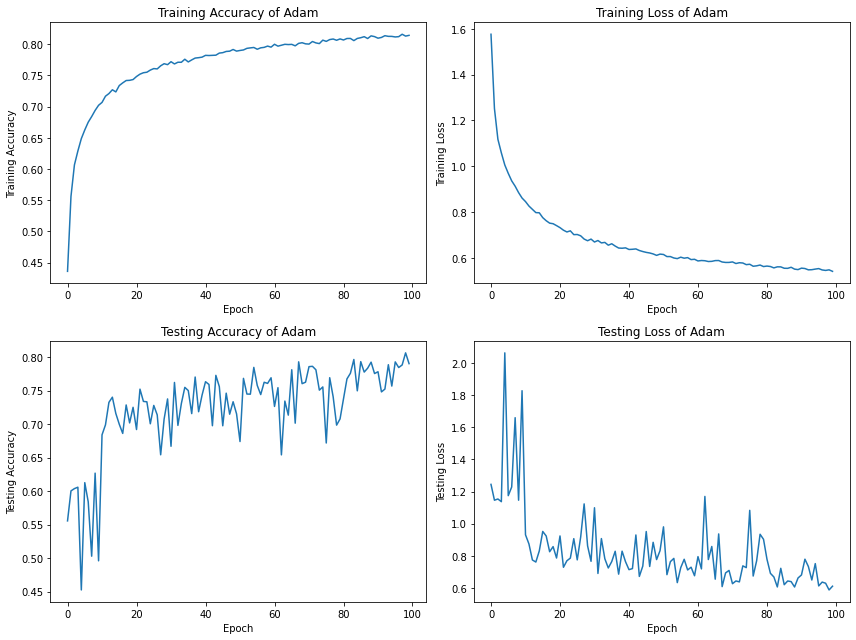

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of Adam')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of Adam')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of Adam')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of Adam')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()